# Set up

In [1]:
src_dir  = "../../data/Preprocessed_data/"
params = list(
  counts   = paste(src_dir, "harmony_cellmarkers_mtx.csv", sep = '/'),
  cell     = paste(src_dir, "harmony_cellmarkers_meta.csv", sep = '/'),
  gene     = paste(src_dir, "harmony_cellmarkers_gene.csv", sep = '/'),
  out_name = "Time_series_rna"
)

In [2]:
# Load libraries
library(here)
library(Seurat)
library(dplyr)
library(stringr)
library(ggplot2)
library(glue)
library(harmony)
library(magrittr)
library(DT)
library(openxlsx)
library(data.table)
library(Matrix)

source("../Utils/Differential_Gene_Expression_Analysis.R")

here() starts at /Users/c3503862/Documents/UoN/ADAPTS/ADAPTS

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Rcpp


Attaching package: 'DT'


The following object is masked from 'package:Seurat':

    JS


The following object is masked from 'package:SeuratObject':

    JS



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last




# Load data

## scRNA-seq counts

In [3]:
# Read gene expression matrix
expression_matrix <- read.csv(params$counts, stringsAsFactors = FALSE)[ ,-1]
expression_matrix <- t(expression_matrix)

# Read cell barcodes
cell_barcodes <- read.csv(params$cell, header = TRUE, stringsAsFactors = FALSE)

# Read gene names
gene_names <- read.csv(params$gene, header = TRUE, stringsAsFactors = FALSE)

# Create Seurat object
seu <- CreateSeuratObject(counts       = expression_matrix, 
                          assay        = "RNA",
                          meta.data    = cell_barcodes,
                          project      = "Time_series_rna")

# Assign gene names
rownames(seu) <- gene_names$X

# Assign cell type
Idents(object = seu) <- "cell_type"


Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


# Normalization

## Log normalization & scaling

In [4]:
# Normalize data
seu <- NormalizeData(
    object               = seu,
    normalization.method = "LogNormalize",
    scale.factor         = 1E4
)
    
# Detection of variable genes across the single cells
seu <- FindVariableFeatures(
    object           = seu,
    selection.method = "vst",
    nfeatures        = 3000
)

# Scaling the data and removing unwanted sources of variation
all.genes <- rownames(seu)
seu <- ScaleData(
  object    = seu,
  features  = all.genes,
  do.scale  = FALSE,
  do.center = TRUE
)


Normalizing layer: counts

Finding variable features for layer counts

Centering data matrix



# Dimension reduction

In [5]:
DefaultAssay(seu) <- "RNA"
# PCA
nPCs <- 50
seu <- RunPCA(
  object   = seu, 
  features = VariableFeatures(object = seu), 
  npcs     = nPCs
)

PC_ 1 
Positive:  HMGB1, TUBA1B, MT2A, PA2G4, CDKN3, S100A2, SLIRP, CMSS1, H2AFZ, TGM2 
	   EIF3J, CKS1B, RPL39L, RPL41, SNRPG, CENPF, LINC00152, COX17, NCL, DDX18 
	   CBX3, NOP56, LSM5, HN1, HMGA1, KRT6A, SNRPD1, RPS29, ANP32B, HMGB2 
Negative:  NEAT1, SOX4, MALAT1, GSTK1, EEF1A1, LINC01420, QPRT, PYCARD, FTH1, PDLIM1 
	   C15orf48, B2M, GPRC5A, FTL, IL32, CYP1B1, TACSTD2, RABAC1, KRT19, HIST1H2BD 
	   MUC4, KRT7, RAB13, PSCA, GLTSCR2, HMGCS1, IGFBP3, NEDD9, CLIC3, C14orf1 
PC_ 2 
Positive:  TGM2, PRELID1, NME4, GLTSCR2, GPRC5A, RPS29, HMGA1, MALAT1, UBE2E3, TOP2A 
	   RDX, FSTL1, AREG, EIF3J, SRM, CBX3, TRBC2, HNRNPAB, ITGA6, FTL 
	   PMEPA1, SVIP, CEACAM6, CMSS1, CMC2, PPM1G, RPL39L, KPNB1, ALDH1A3, ATAD2 
Negative:  BLVRB, AKR1B1, PTGR1, SFN, ENO1, PSMB6, UBB, NQO1, KRT19, PSMB3 
	   AKR1C1, AKR1C3, MYL12A, LGALS1, TXN, PSME2, UCHL1, S100A11, LGALS3, SLC3A2 
	   CLDN7, ACTB, PSMD8, ETFB, ANXA1, AKR1B10, PSMB7, CLIC1, PRDX2, PSMA2 
PC_ 3 
Positive:  TUBA1B, PRELID1, CCDC85B, GLTSCR

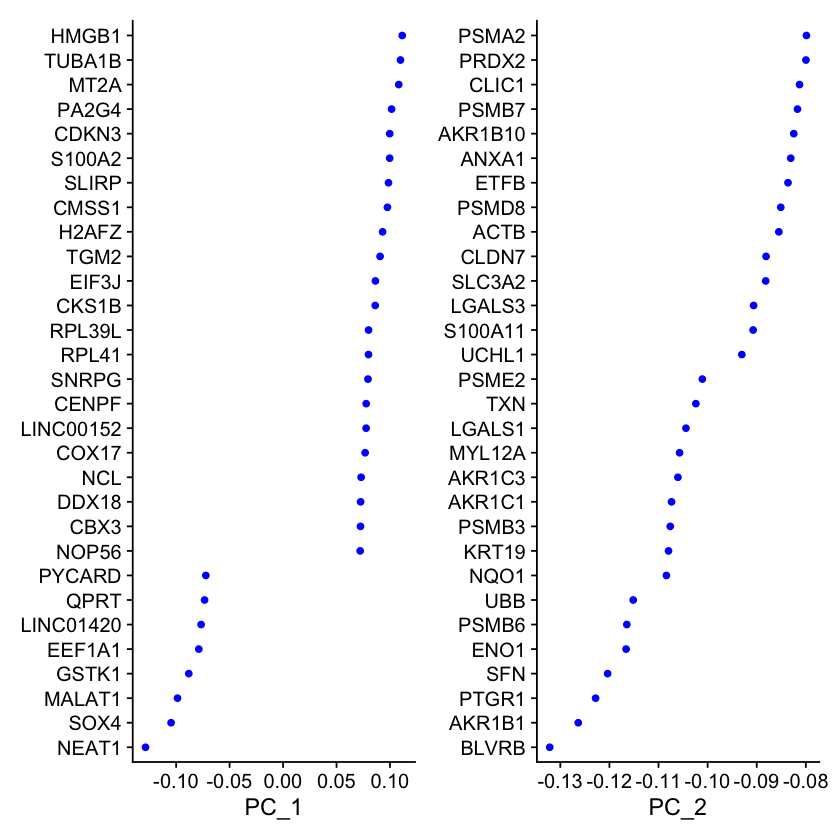

In [6]:
VizDimLoadings(seu, dims = 1:2, reduction = "pca")

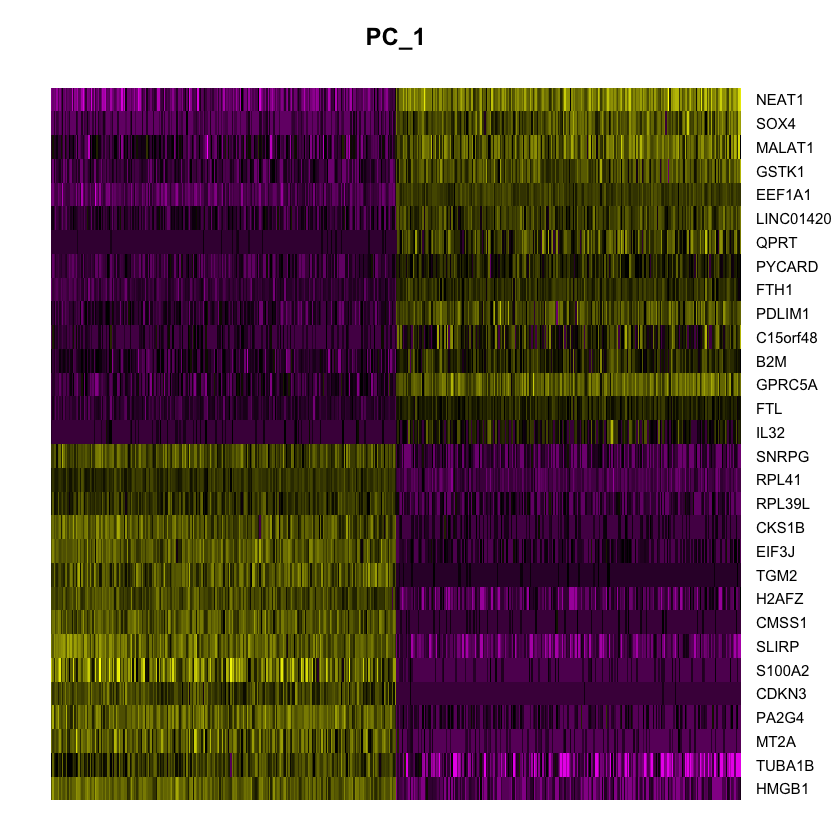

In [7]:
DimHeatmap(seu, dims = 1, cells = 500, balanced = TRUE)

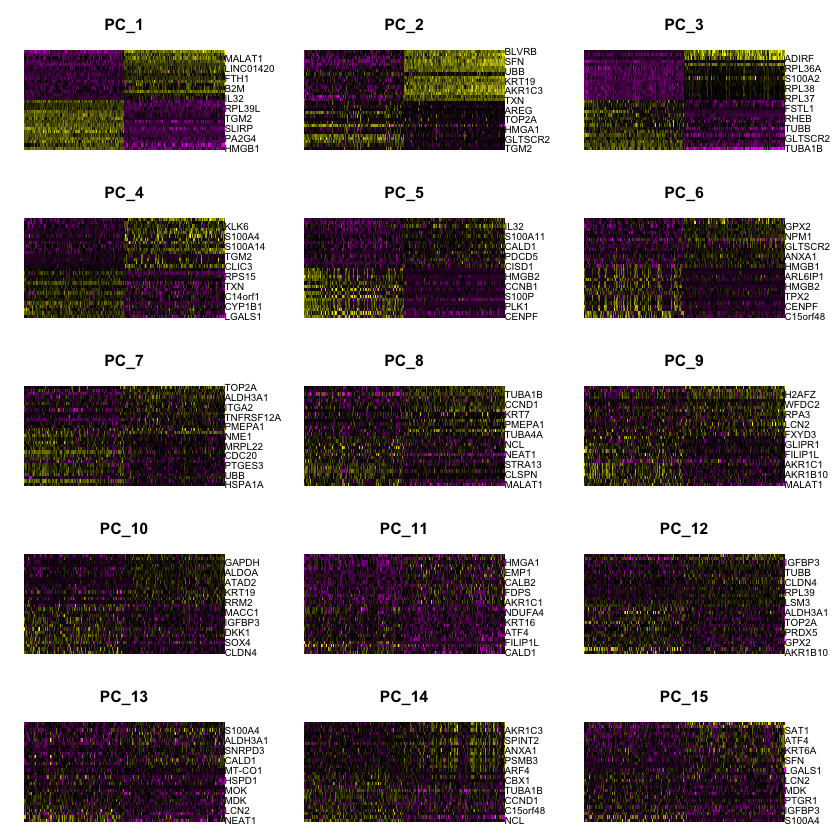

In [8]:
DimHeatmap(seu, dims = 1:15, cells = 500, balanced = TRUE)

Number of Principal Components (npcs) selected: 13



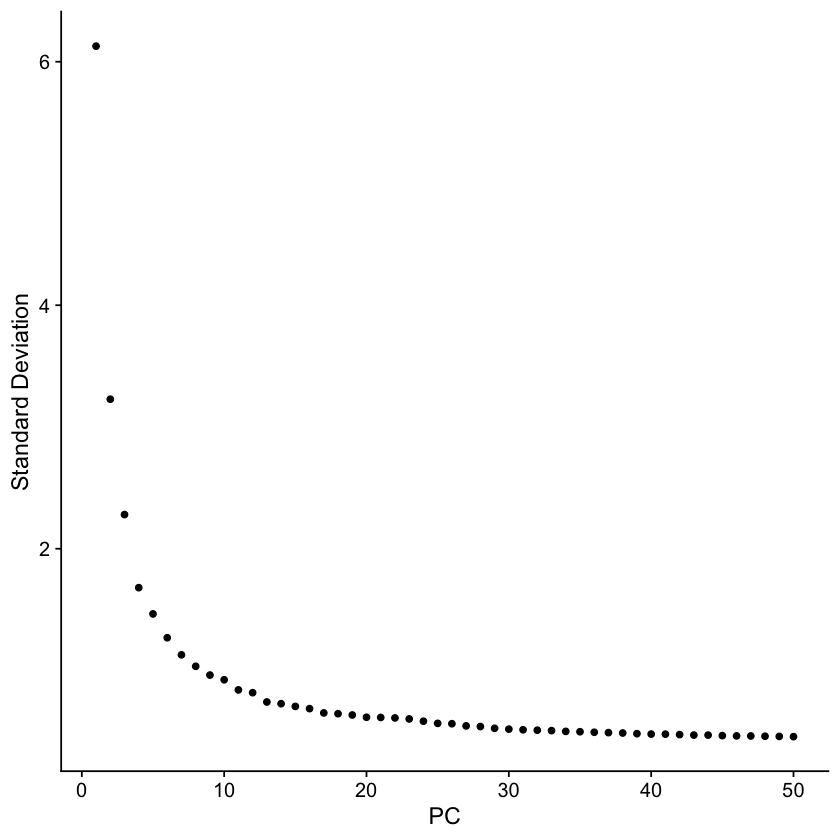

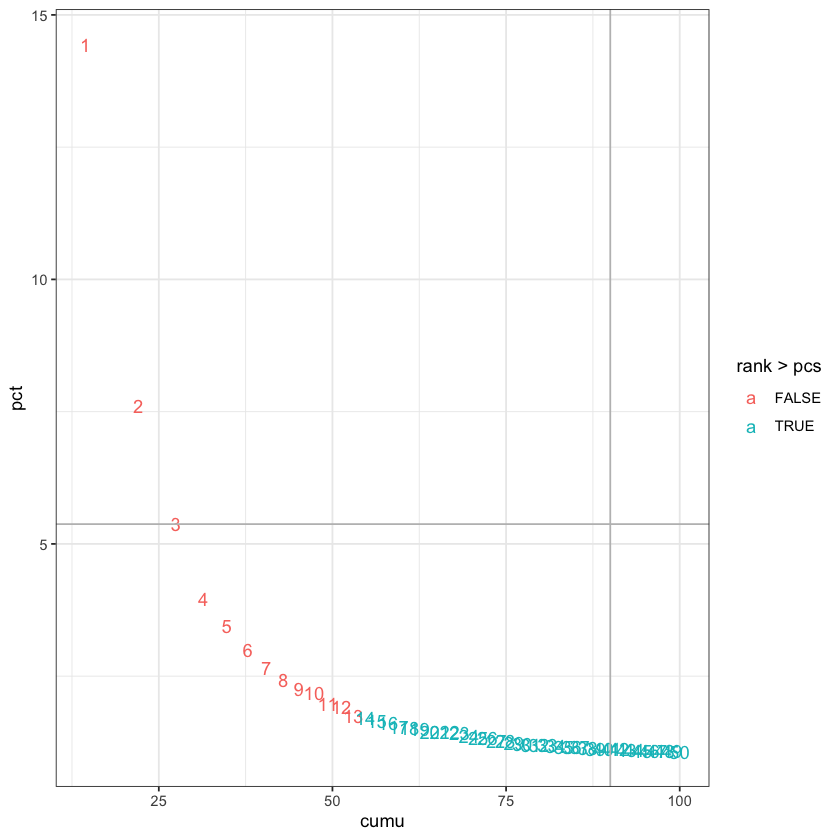

In [9]:
ElbowPlot(object = seu, ndims = nPCs)
pcs <- elbow_pcs(seu, ndims = 50, graph = "pca")

# Harmony data integration 

Warning message:
"Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session."
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



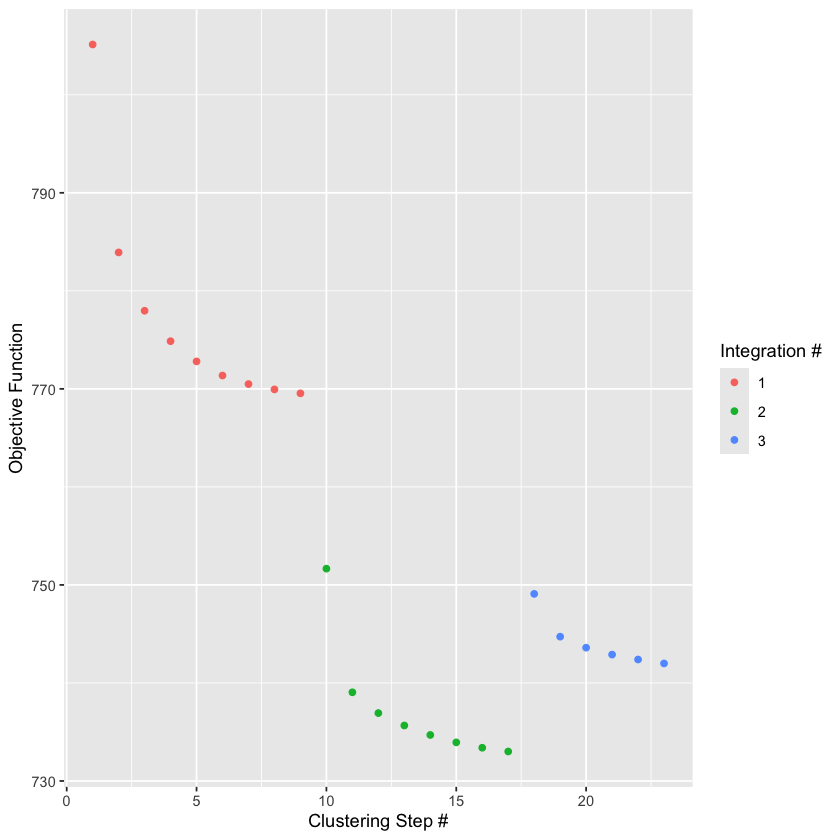

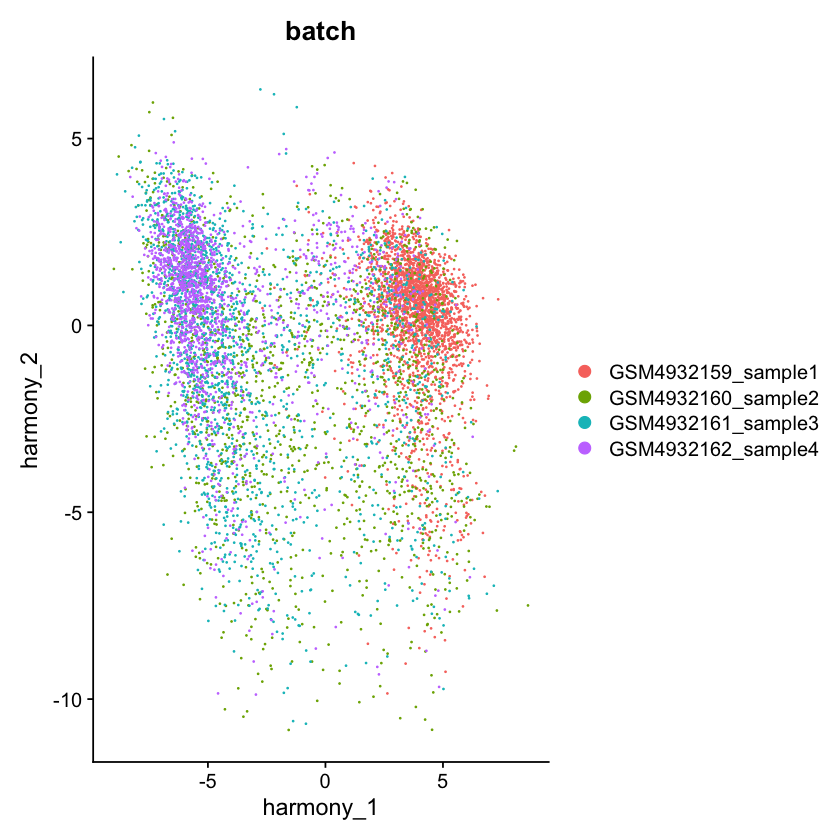

In [10]:
# Run Harmony
seu <- RunHarmony(
  seu,
  "batch",
  theta            = 2, 
  max.iter.harmony = 50,
  plot_convergence = TRUE
)

# Simple dim and vlnplot to examine integration 
DimPlot(object = seu, reduction = "harmony", pt.size = .1, group.by = "batch")

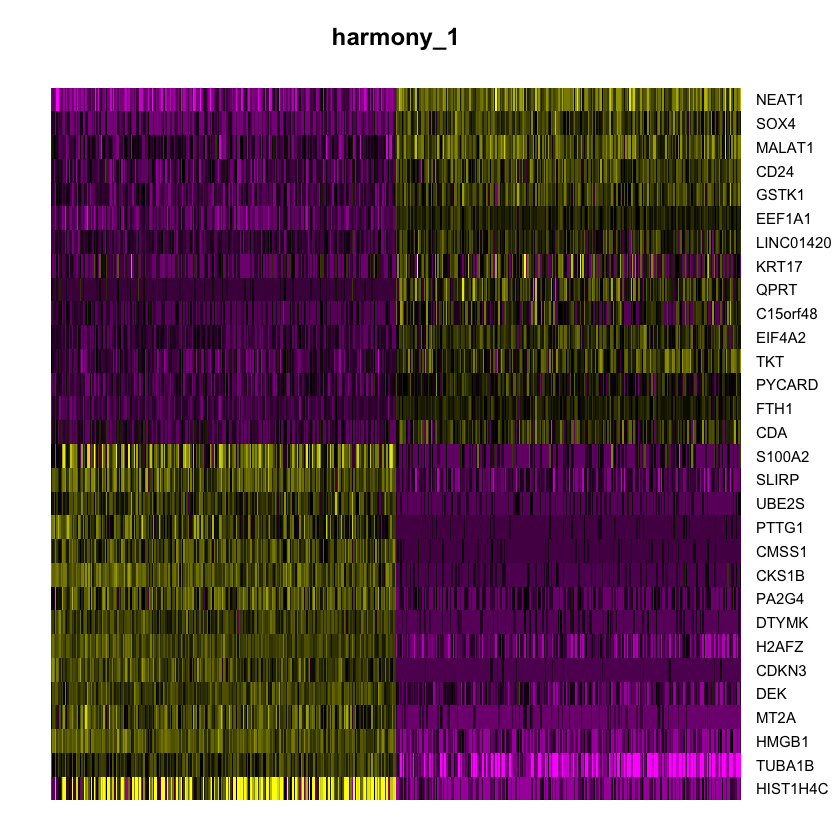

In [11]:
DimHeatmap(seu, dims = 1, cells = 500, balanced = TRUE, reduction = "harmony")


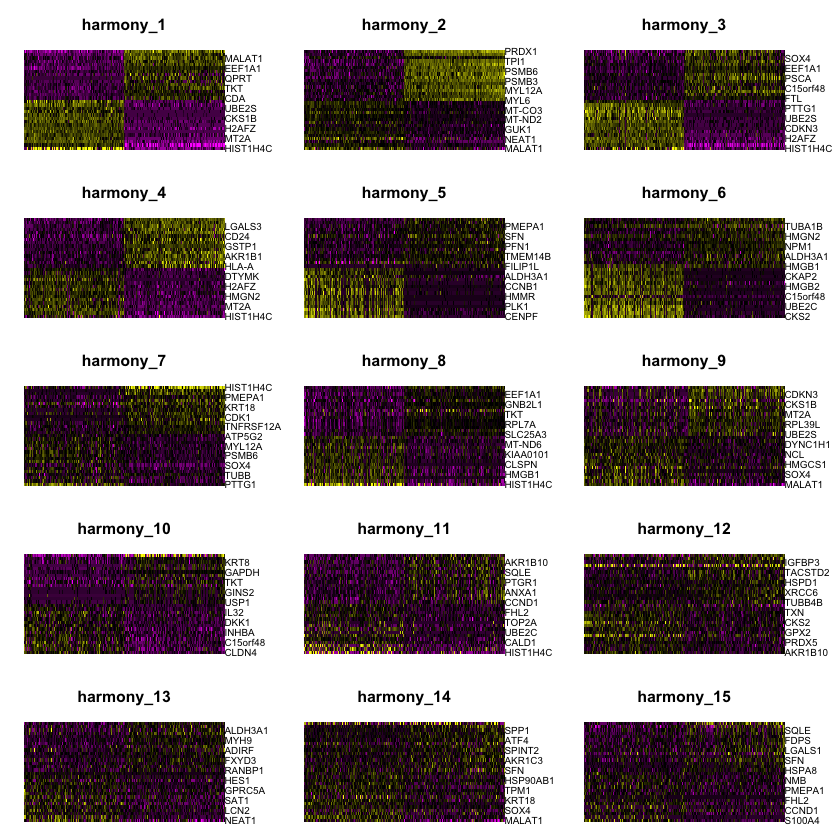

In [12]:
DimHeatmap(seu, dims = 1:15, cells = 500, balanced = TRUE, reduction = "harmony")


# Clustering

Number of Principal Components (npcs) selected: 11



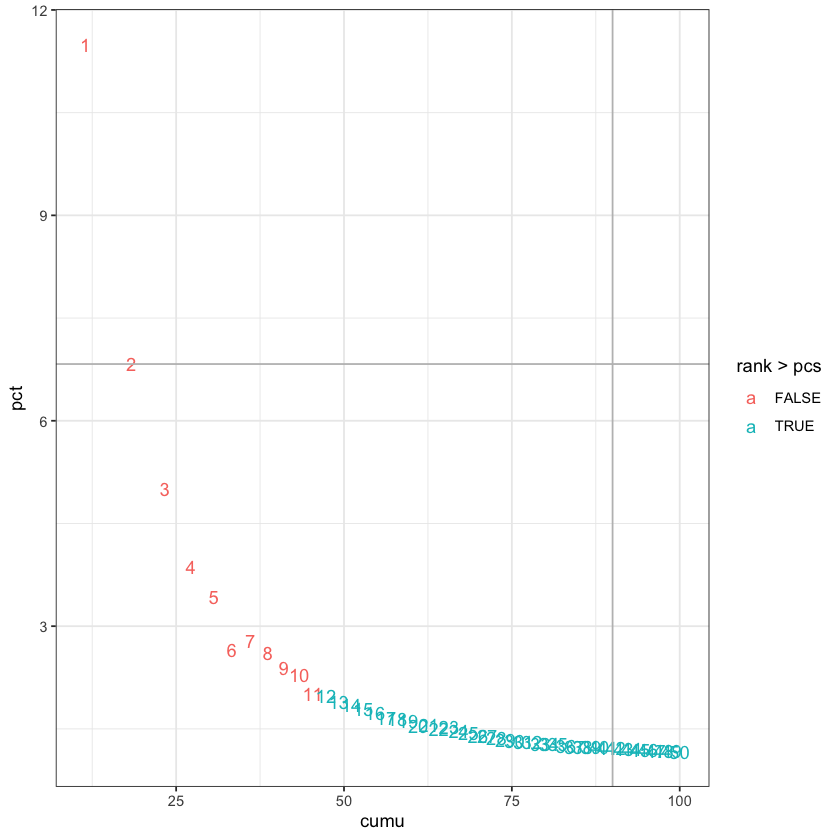

In [13]:
pcs <- elbow_pcs(seu, ndims = 50, graph = "harmony")


In [14]:
resolution <- 0.6
reduction_type <-  "harmony"
dims <-  20
system.time({
seu %<>% RunUMAP(reduction = reduction_type, dims = 1:dims)
seu %<>% FindNeighbors(
  reduction    = reduction_type,
  dims         = 1:dims,
  force.recalc = TRUE
)    
seu %<>% FindClusters(resolution = resolution)
})
# table(Idents(seu))

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:01:08 UMAP embedding parameters a = 0.9922 b = 1.112

16:01:08 Read 7391 rows and found 20 numeric columns

16:01:08 Using Annoy for neighbor search, n_neighbors = 30

16:01:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:01:09 Writing NN index file to temp file /var/folders/y0/1cs3npgn3jn68yvgp05r7ntc0000gr/T//RtmpdTuZON/filef76649dcafda

16:01:09 Searching Annoy index using 1 thread, search_k = 3000

16:01:10 Annoy recall = 100%

16:01:10 Commencing smooth kNN distance calibrat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7391
Number of edges: 279022

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8298
Number of communities: 9
Elapsed time: 0 seconds


   user  system elapsed 
  8.672   0.072   8.814 

# UMAP visualization

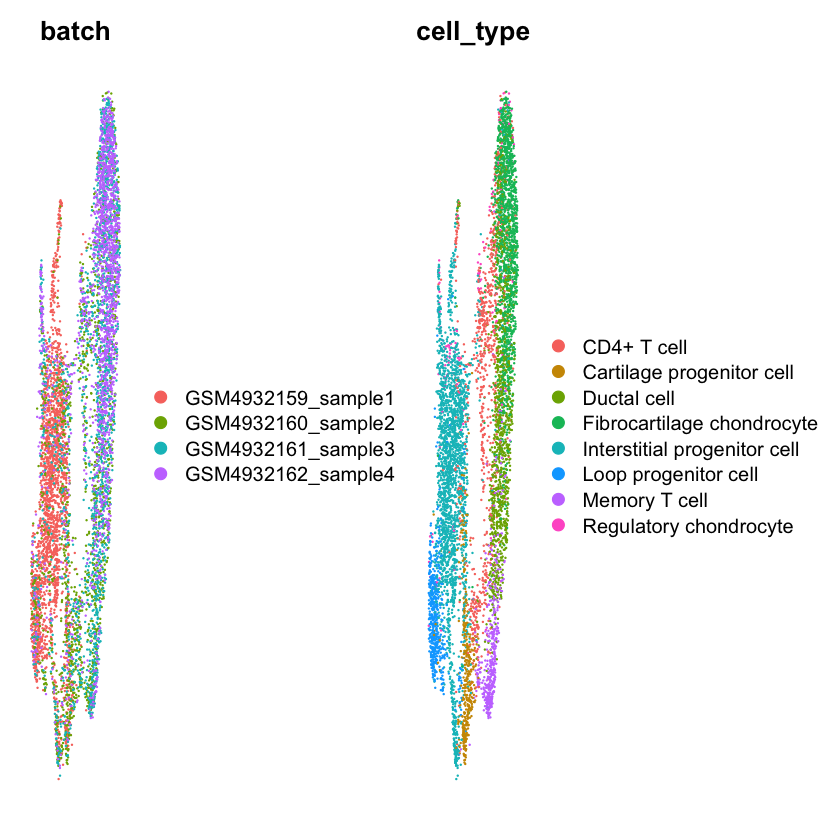

In [15]:
DimPlot(
  object     = seu, 
  group.by   = c("batch", "cell_type"), 
  label      = TRUE, 
  pt.size    = 0.01, 
  label.size = 0
) & NoAxes()

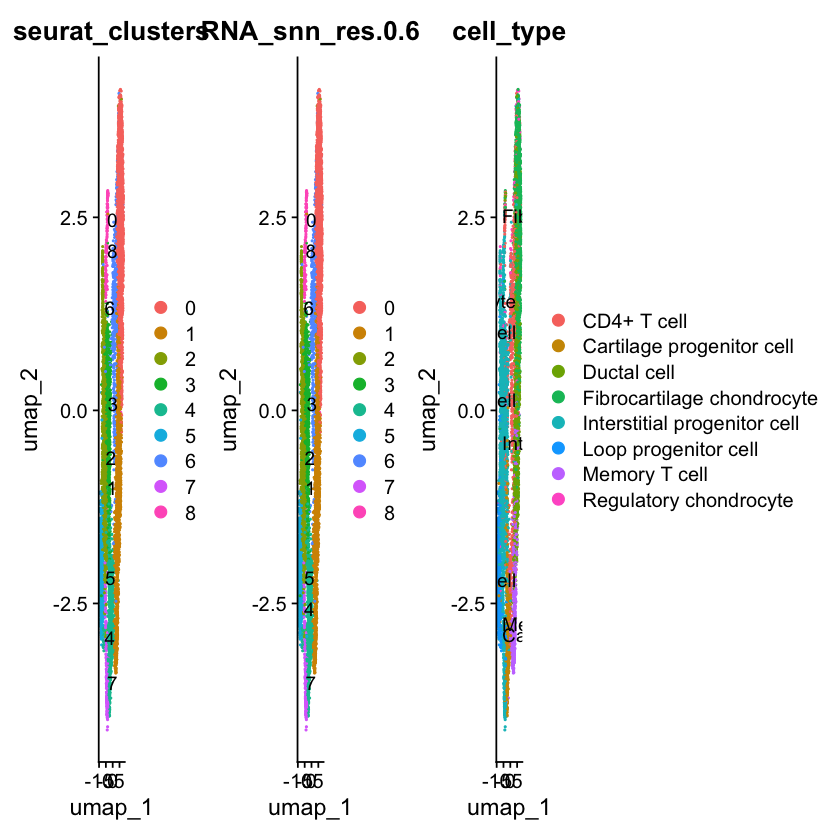

In [16]:
DimPlot(seu, group.by = c("seurat_clusters", "RNA_snn_res.0.6", "cell_type"), ncol = 3, label = TRUE, repel = TRUE)


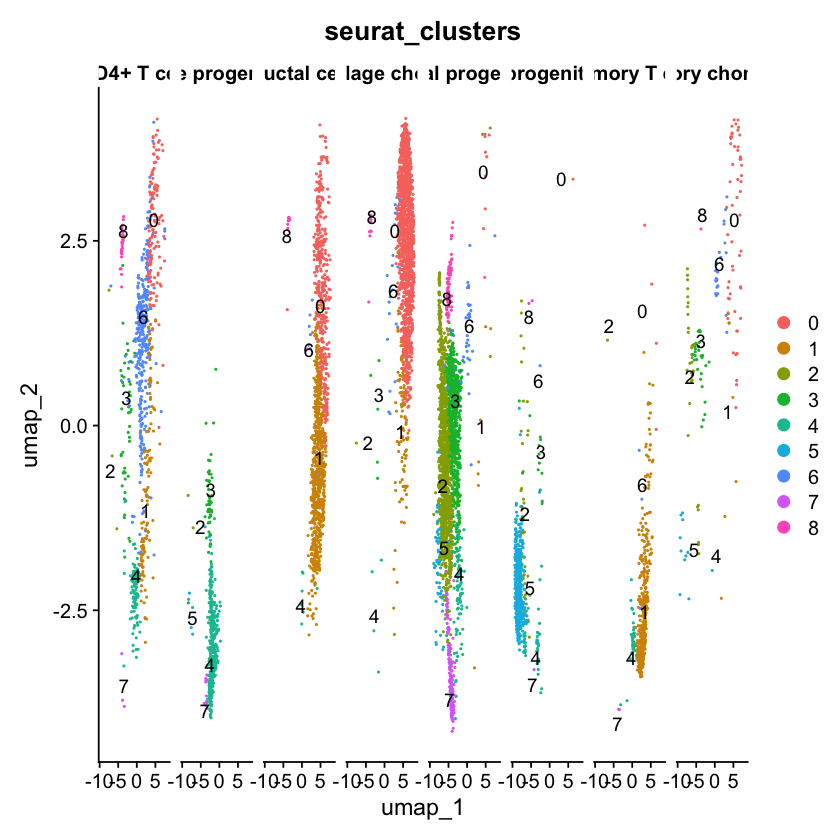

In [17]:
DimPlot(seu, group.by = "seurat_clusters", split.by = "cell_type", label = TRUE, repel = TRUE)


## Save the Seurat object

In [19]:
saveRDS(seu, file = here("data/Preprocessed_data", glue("seu_", params$out_name, ".rds")))
